In [152]:
import pickle

### Set up environment

# import packages
import pandas as pd
import numpy as np
import os
from glob import iglob
#import matplotlib.pyplot as plt
#import seaborn as sns
import random
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
#from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import glob

import json
import csv

# Set parameters
#T = 298      # Kelvin


# define Jeanna's broadening formalism for use later.  Taken from paper ...
def broadening(m, T, ma, mp, b0):
    gamma = 1.7796e-5 * (m/(m-2)) * (1/np.sqrt(T)) * np.sqrt((ma+mp)/(ma*mp)) * b0**2
    return(gamma)





In [181]:

### Read in data

# import data

# absolute path to folder containing data
#rootdir_glob = '/Users/elizabeth/Desktop/line_broadening.nosync/line_broadening/hitran_data/**/*'
# be selective for data files
#file_list = [f for f in iglob(rootdir_glob, recursive=True) if os.path.isfile(f) if f[-10:] == "/1_iso.csv" if "readme" not in f]
#file_list = 
#path = '/Users/elizabeth/Desktop/line_broadening.nosync/line_broadening/model_search/*'
#file_list = glob.glob(path + 'raw_data/*.csv')

path = '/Users/elizabeth/Desktop/line_broadening.nosync/line_broadening/Other_broadeners/Files_with_new_data/'
file_list = glob.glob(path+'*.csv')

# read data files, taking the filename from absolute path
db = {}
for f in file_list:
    i = f[101:104].strip('_')
    j = f[106:109].strip('_')
    file = pd.read_csv(f, low_memory=False, index_col=0, dtype={'J':np.float64, 'Jpp':np.float64})
    
    if i+j in db:
        db[i+'_'+j] = pd.concat([db[i+'_'+j], file]).reset_index(drop=True)
    else:
        db[i+'_'+j] = file.reset_index(drop=True)
        
print(len(db))


13


In [203]:
file = pd.read_excel(path+'Broadening_data_from_smaller_sources.xlsx', dtype={'J':np.float64, 'Jpp':np.float64})
file = file[['molecule', 'broadener', 'J', 'Jpp', 'Ka_aprox', 'Kapp_aprox', 'Kc_aprox', 'Kcpp_aprox', 'gamma', 'gamma_uncertainty', 'n', 'T', 'profile', 'paper']].dropna()

In [204]:
file

,molecule,broadener,J,Jpp,Ka_aprox,Kapp_aprox,Kc_aprox,Kcpp_aprox,gamma,gamma_uncertainty,n,T,profile,paper
1,O2,H2O,20.0,21.0,0.0,0,20.0,21.0,0.046000,0.00600,0.6626,296.0,Galatry,3
2,O2,H2O,20.0,20.0,0.0,0,20.0,20.0,0.051000,0.00500,0.6726,296.0,Galatry,3
3,O2,H2O,18.0,19.0,0.0,0,18.0,19.0,0.052000,0.00200,0.6825,296.0,Galatry,3
4,O2,H2O,18.0,18.0,0.0,0,18.0,18.0,0.051000,0.00400,0.6952,296.0,Galatry,3
5,O2,H2O,16.0,17.0,0.0,0,16.0,17.0,0.049000,0.00100,0.7079,296.0,Galatry,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,OH,Ar,6.5,6.5,0.0,0,6.5,6.5,0.097000,0.01455,------------,500.0,Lorentzian,30
1111,OH,Ar,7.5,7.5,0.0,0,7.5,7.5,0.094600,0.01419,------------,500.0,Lorentzian,30
1112,CH3F,CH3Br,2.0,1.0,1.0,1,1.0,0.0,0.394967,0.00760,1,300.0,Voigt,32
1113,CH3F,CH3F,2.0,1.0,1.0,1,1.0,0.0,0.449978,0.00887,0.96,300.0,Voigt,32


In [205]:

#create unique list of names
actives = file.molecule.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in actives}

for key in DataFrameDict.keys():
    DataFrameDict[key] = file[:][file.molecule == key]

dfd3 = {}
for item, data in DataFrameDict.items():
    perts = data.broadener.unique()
    dfd2 = {elem : pd.DataFrame() for elem in perts}
    for key in dfd2.keys():
        dfd2[key] = data[:][data.broadener == key]
        dfd3[item+'_'+key] = dfd2[key]

In [207]:
for key, data in dfd3.items():
    i, j = str.split(key, '_')
    if i+j in db:
        db[i+'_'+j] = pd.concat([db[i+'_'+j], data]).reset_index(drop=True)
    else:
        db[i+'_'+j] = data.reset_index(drop=True)

In [208]:
print(len(db))

34


In [209]:
molecule_parameters = pd.read_csv('/Users/elizabeth/Desktop/line_broadening.nosync/line_broadening/molecule_parameters.csv', index_col=0)

In [210]:
molecule_parameters

,weight,dipole,m,d,polar,B0a,B0b,B0c
CS2,76.141000,0.0000,2.0,460.00,8.749000,100000.000000,0.109100,0.109100
CS,44.071000,1.9570,2.0,358.00,5.396845,100000.000000,0.817084,0.817084
COF2,66.006900,0.9510,2.0,400.00,2.800000,0.394058,0.392039,0.196166
NO2,46.005500,0.3160,2.0,346.00,2.910000,8.002336,0.433700,0.410451
O3,47.998200,0.5337,4.0,400.00,3.079000,3.553666,0.445283,0.394752
...,...,...,...,...,...,...,...,...
SiN,41.980001,2.7720,2.0,462.99,7.351000,100000.000000,0.731100,0.731100
ZrO,105.899612,2.5510,2.0,431.20,6.754000,100000.000000,0.422630,0.422630
YO,104.900755,4.5240,2.0,456.20,18.771000,100000.000000,0.388100,0.388100
FeH,56.942761,2.6300,2.0,585.20,9.178000,100000.000000,6.484820,6.484820


In [218]:
    

# dictionary of molecules of data - condensed version
molecules = {}

# take only molecules for which there is full data
for key, data in db.items():
    active, perturber = str.split(key, '_')
    print(active)
    print(perturber)
    if perturber == 'Ar':
        continue
    if active == 'CHF3':
        continue
    if active == '13CO':
        continue
    print('~~~~~~~~~~~~~~~')
    
    
    if 'local_iso_id' in data.columns:
        data = data[data['local_iso_id']==1]

    
    active_params = molecule_parameters.loc[active]
    pert_params = molecule_parameters.loc[perturber]
    

    for index, info in active_params.items():
        data['active_'+index] = info
    for index, info in pert_params.items():
        data['perturber_'+index] = info
    data = data[['J', 'Ka_aprox', 'Kc_aprox',
       'Jpp', 'Kapp_aprox', 'Kcpp_aprox', 'T', 'profile', 'gamma', 'gamma_uncertainty',
       'active_weight', 'active_dipole', 'active_m', 'active_d',
       'active_polar', 'active_B0a', 'active_B0b', 'active_B0c',
       'perturber_weight', 'perturber_dipole', 'perturber_m', 'perturber_d',
       'perturber_polar', 'perturber_B0a', 'perturber_B0b', 'perturber_B0c']]
    data['m'] = data['active_m'] + data['perturber_m']
    data['d_act_per'] = data['active_d']/2 + data['perturber_d']/2
    data = data.drop(['active_d', 'active_m', 'perturber_d', 'perturber_m'], axis=1)
    
    data['fractional_error'] = data['gamma_uncertainty']/data['gamma']
    
        
    print(len(data))
    data = data.dropna()
    print(len(data))
    data = data[data['gamma']!=0]
    data = data[data['gamma_uncertainty']!=0]

        
    branch = data['Jpp'] - data['J']
    data = data.drop(branch[abs(branch)>2].index)
    print(len(data))
    branch = data['Jpp'] - data['J']

    data['P'] = -data['Jpp'][branch==1]
    data['Q'] = data['Jpp'][branch==0]
    data['R'] = data['Jpp'][branch==-1] +1
    data['O'] = -data['Jpp'][branch==2]
    data['S'] = data['Jpp'][branch==-2] +1

    data['P'] = data['P'].fillna(0)
    data['Q'] = data['Q'].fillna(0)
    data['R'] = data['R'].fillna(0)
    data['O'] = data['O'].fillna(0)
    data['S'] = data['S'].fillna(0)

    data['M'] = data['P'] + data['Q'] + data['R'] + data['O'] + data['S']
    data = data.drop(columns=['P', 'Q', 'R', 'O', 'S']).reset_index()


    molecules[key] = data
    broadness_jeanna = broadening(data['m'][0], data['T'][0], data['active_weight'][0], data['perturber_weight'][0], data['d_act_per'][0])
    molecules[key]['broadness_jeanna'] = broadness_jeanna
           

H2O
CO2
~~~~~~~~~~~~~~~
11607
11607
11607
CO2
N2
~~~~~~~~~~~~~~~
156650
156650
156650
CO2
O2
~~~~~~~~~~~~~~~
156650
156650
156650
CO2
CO2
~~~~~~~~~~~~~~~
3130
2879
2742
H2O
air
~~~~~~~~~~~~~~~


/var/folders/rq/8prqh34x6vj4hqbm2_ssk_ch0000gn/T/ipykernel_2877/2793554713.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['active_'+index] = info
/var/folders/rq/8prqh34x6vj4hqbm2_ssk_ch0000gn/T/ipykernel_2877/2793554713.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['perturber_'+index] = info
/var/folders/rq/8prqh34x6vj4hqbm2_ssk_ch0000gn/T/ipykernel_2877/2793554713.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

140050
140050
140050
O3
O2
~~~~~~~~~~~~~~~
2712
2712
2711
O3
O3
~~~~~~~~~~~~~~~
4450
4450
4450
H2O
O2
~~~~~~~~~~~~~~~
783
775
773
H2O
H2O
~~~~~~~~~~~~~~~
46987
46980
46959
H2O
N2
~~~~~~~~~~~~~~~
8325
7767
7759
O3
N2
~~~~~~~~~~~~~~~
2930
2930
2930
CO2
air
~~~~~~~~~~~~~~~
1843
1750
1743
O3
air
~~~~~~~~~~~~~~~
1524
1524
1524
O2
H2O
~~~~~~~~~~~~~~~
39
39
39
O2
O2
~~~~~~~~~~~~~~~
40
40
40
NO
N2
~~~~~~~~~~~~~~~
94
94
94
NO
CO2
~~~~~~~~~~~~~~~
2
2
2
NO
Ar
NO
H2
~~~~~~~~~~~~~~~
2
2
2
NO
O2
~~~~~~~~~~~~~~~
2
2
2
NO
He
~~~~~~~~~~~~~~~
2
2
2
CHF3
CHF3
CHF3
CH4
CHF3
CF4
CHF3
SF6
CHF3
CCl4
NH
Ar
NH2
Ar
13CO
He
13CO
Ar
OH
Ar
CH3F
CH3Br
~~~~~~~~~~~~~~~
1
1
1
CH3F
CH3F
~~~~~~~~~~~~~~~
1
1
1
CH3F
NH3
~~~~~~~~~~~~~~~
1
1
1


In [219]:
molecules[('H2O_CO2')]

,index,J,Ka_aprox,Kc_aprox,Jpp,Kapp_aprox,Kcpp_aprox,T,profile,gamma,...,perturber_dipole,perturber_polar,perturber_B0a,perturber_B0b,perturber_B0c,m,d_act_per,fractional_error,M,broadness_jeanna
0,1,19.0,2,18,19.0,3,17,296,Voigt,0.0502,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,19.0,0.041101
1,2,19.0,1,18,19.0,2,17,296,Voigt,0.0501,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,19.0,0.041101
2,4,12.0,3,9,12.0,6,6,296,Voigt,0.0976,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,12.0,0.041101
3,6,15.0,7,8,14.0,2,13,296,Voigt,0.0913,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,15.0,0.041101
4,9,11.0,9,3,10.0,2,8,296,Voigt,0.1093,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,11.0,0.041101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11602,21001,14.0,6,9,15.0,6,10,296,Voigt,0.0600,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,-15.0,0.041101
11603,21004,15.0,5,11,16.0,2,14,296,Voigt,0.0680,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,-16.0,0.041101
11604,21005,15.0,4,11,15.0,3,12,296,Voigt,0.0721,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,15.0,0.041101
11605,21007,9.0,5,5,8.0,6,2,296,Voigt,0.0969,...,0.0,2.507,100000.0,0.39021,0.39021,6.0,307.75,0.05,9.0,0.041101


In [220]:
    


###  Investigate data

# Work out the average error codes of each molecule.  Count how many of each error code, and how many points there are

# list of molecule names
molecule_names = []
# list of the proportion of data that is code 3 or above for each molecule
error_2s = []
# list of the number of points each molecule contains
datapoints = []

for key, data in molecules.items():
    molecule, broadener = key.split('_')
    molecule_names.append(key)
    x = data['fractional_error']
    error_2s.append(x.ge(1.0).count()/len(x))
    datapoints.append(len(x))

        

# Print out how much data there is which is 'good' (out of every datapoint)
e2 = np.array(error_2s)
dat = np.array(datapoints)
good_data = e2*dat
print('percentage "good" data =')
print(str(100*sum(good_data)/sum(dat))+'%')

largest_data = max(datapoints)
total_data = sum(datapoints)




percentage "good" data =
100.0%


In [221]:
largest_data

156650

In [222]:
print(total_data)

536732


In [224]:

### Prepare data for use

'''
# reset molecules so that all molecules have the same number of points
for molecule, data in molecules.items():
    # normalise the amount of data compared to the molecule with the most data (SO2)
    points = 549424//len(data)
    #print(len(data))
    # repeat data n times, until each has roughly the same amount of data
    data = pd.concat([data]*points)
    # assign data back to dictionar
    molecules[molecule] = data
'''

# weight data by error code, currently error code = weighting
for key, data in molecules.items():
    active, perturber = str.split(key, '_')

    # take weight as gamma-air-err
    #data=data.sample(frac=1)
    weight = data['fractional_error']
    # Give helpful weightings
    # reweight 0 to tiny, because 0 gives /0 error
        
    
    weight22 = (1/weight)**2
    # reassign weight into dictionary
    data['weight'] = weight22
    weighting_for_this_molecule = largest_data/len(data) / 10000
    datas=[]
    for index, row in data.iterrows():
        weighting = row['weight']
        #amount_data = len(weight[weight==weight_value])
    
        #print(weight_value)
        #print(amount_data)
        #fraction = amount_data / len(data)
        weighting_for_this_datapoint = weighting
        points = round(weighting_for_this_molecule * weighting_for_this_datapoint)
        print(points)
        if points == 0:
            continue
        else:
            row = pd.DataFrame(row).transpose()
            datas.append(pd.concat([row for i in range(round(points))], axis=0))
        #print(fraction)
        #print('fraction kept = '+str(points)) 
        #print()
        #print(row.sample(frac=points, replace=True, axis=1))
        #datas.append(row.sample(frac=points, replace=True))
        

        break
    data = pd.concat(datas)
    # assign data back to dictionary
    molecules[key] = data
    
        
        
    '''average_weight = np.mean(weight)
    points = 600000000*average_weight/len(data)
    print(molecule)
    print('avg_weighting = '+str(average_weight))
    print('fraction kept = '+str(points)) 
    print()
    data = data.sample(frac=points, replace=True)
    #data = pd.concat([data]*points)
    # assign data back to dictionary
    molecules[molecule] = data
    '''


1253
19581
15665
176
7098
269
449
77
4364
804
289
174
152
4
4
9
258861
217590
59822
288868
42308
40315
56163


In [225]:
print(molecules.keys())

dict_keys(['H2O_CO2', 'CO2_N2', 'CO2_O2', 'CO2_CO2', 'H2O_air', 'O3_O2', 'O3_O3', 'H2O_O2', 'H2O_H2O', 'H2O_N2', 'O3_N2', 'CO2_air', 'O3_air', 'O2_H2O', 'O2_O2', 'NO_N2', 'NO_CO2', 'NO_H2', 'NO_O2', 'NO_He', 'CH3F_CH3Br', 'CH3F_CH3F', 'CH3F_NH3'])


In [226]:
molecules

{'H2O_CO2':    index     J Ka_aprox Kc_aprox   Jpp Kapp_aprox Kcpp_aprox    T profile  \
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 ..   ...   ...      ...      ...   ...        ...        ...  ...     ...   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 0      1  19.0        2       18  19.0          3         17  296   Voigt   
 
      gamma  ... perturber_polar perturber_B0a pert

In [227]:


'''
# reset molecules so that all molecules have the same number of points
for molecule, data in molecules.items():
    # normalise the amount of data compared to the molecule with the most data (SO2)
    print(len(data))
    weight = 950863/len(data)
    #weight = 549424/len(data)
    # assign data back to dictionary
    molecules[molecule]['gamma_air-err'] = data['gamma_air-err']*weight
'''

import random
keys = list(molecules.items())
random.seed(41)
random.shuffle(keys)
molecules = dict(keys)
    
# Dictionary of molecules, and test/training data
molecule_list = {}

# test data set size
n = 5


# collect 'training data' from all other molecules, except the labelled one
i=0
# collect 'training data' from all other molecules, except the labelled one
for molecule in molecules:
    if not i%n:
        print(i)
        # molecule is being tested
        test_data = {k: molecules[k] for k in list(molecules)[i:i+n]}
        #data_test = molecules[molecule]
        # take test molecule out of dictionary
        train_data = set(molecules) - set(test_data)
        #print(test_data)
        #print(test_data.keys(), train_data)
        # dictionary of molecules in test data
        train_data = {k: molecules[k] for k in train_data}
        
        # All test data in one dataframe
        data_test = pd.concat([test_data[k] for k in test_data])

        # Take all train data into one dataframe
        data_train = pd.concat([train_data[k] for k in train_data])
        
        # add data into molecule_list dictionary
        moles = ','.join(list(test_data.keys()))
        molecule_list[moles] = [data_train, data_test]
        
    i+=1
    



#print(molecule_list)


0
5
10
15
20


In [228]:
molecule_list

{'H2O_air,NO_CO2,O2_O2,NO_He,CO2_O2': [   index     J Ka_aprox Kc_aprox   Jpp Kapp_aprox Kcpp_aprox      T  \
  0      0  12.5      0.0     12.5  11.5          0       11.5  294.0   
  0      0  12.5      0.0     12.5  11.5          0       11.5  294.0   
  0      0  12.5      0.0     12.5  11.5          0       11.5  294.0   
  0      0  12.5      0.0     12.5  11.5          0       11.5  294.0   
  0      0  12.5      0.0     12.5  11.5          0       11.5  294.0   
  ..   ...   ...      ...      ...   ...        ...        ...    ...   
  0      0   7.0        2        6   6.0          2          5    296   
  0      0   7.0        2        6   6.0          2          5    296   
  0      0   7.0        2        6   6.0          2          5    296   
  0      0   7.0        2        6   6.0          2          5    296   
  0      0   7.0        2        6   6.0          2          5    296   
  
         profile    gamma  ... perturber_polar perturber_B0a perturber_B0b  \
  0   

In [229]:



'''
# concatenate all dataframes once
data_train_all = pd.concat(list(molecules.values()))


molecule_list = {}

a = []
for i, data_test in enumerate(list(molecules.values())):
    # slice the concatenated dataframe
    data_train = pd.concat([data_train_all.iloc[:i*len(molecule_list)], data_train_all.iloc[(i+1)*len(molecule_list):]])

    molecule_list[list(molecules.keys())[i]] = [data_train, data_test]


'''
'''
# Dictionary of molecules, and test/training data
molecule_list = {}

# collect 'training data' from all other molecules, except the labelled one
for molecule in molecules:
    # molecule is being tested
    data_test = molecules[molecule].to_numpy()
    # take test molecule out of dictionary
    train_data = {}
    for k in molecules:
        if k != molecule:
            train_data[k] = molecules[k].to_numpy()

    data_train = np.concatenate([train_data[k] for k in train_data])
    molecule_list[molecule] = [data_train, data_test]
'''


'''
def what_is_error(weight):
    if weight == (1/500000)**2:
        weight = 'Unavailable'
    if weight == (1/20000)**2:
        weight = 'Constant'
    if weight == (1/1000)**2:
        weight = 'Estimate'
    if weight == (1/50)**2:
        weight = '>20%'
    if weight == (1/15)**2:
        weight = '20> >10%'
    if weight == (1/10)**2:
        weight = '<10%'
    return weight

'''

plot_data_list = []

In [230]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Machine learning!
#print('Can you get to the start of ML?')

## start machine learning
#total_1oerr2 = 0
#total_1oerr = 0
#total_err = 0
#total_err2 = 0
#total_1orterr = 0
#total_nowt = 0
#total_MLP = 0
counter = 0
pipe_container = []

total = 0
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, lognorm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import export_graphviz
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor
#>>> from sklearn.pipeline import Pipeline
#>>> import numpy as np
flag = False
#kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))
# learn on each molecule
for key, data in molecule_list.items():
    print(len(data[1]))
    print(data[1].columns)

    #print(key)
    #molecule, broadener = key.split('_')
    # print out which molecule we're looking at
    #counter += 1
    #if counter < 1:
    #    continue
    
    #distributions = dict(histgradientboostingregressor__loss=['least_squares', 'least_absolute_deviation', 'poisson'],# 'quantile'],
    #                      histgradientboostingregressor__learning_rate=lognorm(2),         histgradientboostingregressor__learning_rate=uniform(loc=0.2, scale=0.9))
    #                      #histgradientboostingregressor__max_iter=np.random.randint(10, 1000, 1000),       #lognorm(1.5, scale=300),
    #                      #histgradientboostingregressor__max_leaf_nodes=np.random.randint(2, 100, 1000),              #uniform(loc=0, scale=300),
    #                      #histgradientboostingregressor__l2_regularization=uniform(loc=0, scale=10)) 
    


    #distributions = dict(histgradientboostingregressor__min_samples_leaf=[1000, 100, 20, 5, 1])
    #distributions = dict(mlpregressor__hidden_layer_sizes=[(100, 100), (1000, 1000), (5000, 500), (500, 5000)], 
    #                     mlpregressor__activation=['tanh', 'relu'],
    #                     mlpregressor__alpha=[0.0001, 0.001, 0.01])
    
    #if key == 'HO2':
    #    flag=True
    #elif key == 'NO':
    #    flag=False
    #print(molecule)
    #if flag == False:
    #    continue
    
    
    # take out training and test data
    data_train = data[0]
    data_test = data[1]
    
    # Check if there are null values
    #if data_train.isnull().values.any():
    #    raise ValueError("We're getting null values here, might be good to cut them out")

    # shuffle data, randomised lines of each molecule for machine learning
    print(len(data_train))
    data_test = data_test.sample(frac=1)
    print("lets train!!!")
    data_train = data_train.sample(frac=0.01)
    

    #print('data splitted')



    # Training data - separate out all x values and y (broadening) values.  gamma-err is weighting
    X_train = data_train.drop(['gamma', 'gamma_uncertainty', 'fractional_error', 'weight', 'profile'], axis=1)
    y_train = data_train['gamma']
    weight_train = data_train['weight']
    #weight_train_1ovsquare = data_train['gamma_air-err']
    #weight_train_1overr = np.sqrt(data_train['gamma_air-err'])
    #weight_train_err = 1/np.sqrt(data_train['gamma_air-err'])
    #weight_train_err_sq = 1/data_train['gamma_air-err']
    #weight_train_1ovsq_root = np.sqrt(np.sqrt(data_train['gamma_air-err']))
    #weight_train = np.sqrt(data_train['gamma_air-err'])
    #weight_train = np.sqrt(data_train['gamma_air-err'])
    # Separate out test data
    X_test = data_test.drop(['gamma', 'gamma_uncertainty', 'fractional_error', 'weight', 'profile'], axis=1)
    y_test = data_test['gamma']
    weight_test = data_test['weight']
    #weight_test_1ovsquare = data_test['gamma_air-err']
    #weight_test_1overr = np.sqrt(data_test['gamma_air-err'])
    #weight_test_err = 1/np.sqrt(data_test['gamma_air-err'])
    #weight_test_err_sq = 1/data_test['gamma_air-err']
    #weight_test_1ovsq_root = np.sqrt(np.sqrt(data_test['gamma_air-err']))

    
    #pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2))

    #FINALLLLL
    
    # Create pipeline of scaling, then ML method
    pipe = make_pipeline(StandardScaler(), VotingRegressor(
                                               estimators=[('hist', HistGradientBoostingRegressor()),
                                                           ('ada', AdaBoostRegressor()),
                                                           ('svr', SVR()),
                                                           ('forest', RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2)),
                                                           ('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]
                                                , n_jobs=-1, verbose=True
                                               ))

    
    '''
    pipe1 = make_pipeline(StandardScaler(), VotingRegressor(
                                               estimators=[#('hist', HistGradientBoostingRegressor(learning_rate=1, max_leaf_nodes=None, random_state=42)),
                                                           ('ada', AdaBoostRegressor()),
                                                           ('svr', SVR()),
                                                           ('forest', RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2)),
                                                           ('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]
                                                , n_jobs=-1, verbose=True
                                               ))
    pipe2 = make_pipeline(StandardScaler(), VotingRegressor(
                                               estimators=[('hist', HistGradientBoostingRegressor(learning_rate=1, max_leaf_nodes=None, random_state=42)),
                                                           #('ada', AdaBoostRegressor()),
                                                           ('svr', SVR()),
                                                           ('forest', RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2)),
                                                           ('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]
                                                , n_jobs=-1, verbose=True
                                               ))
    pipe3 = make_pipeline(StandardScaler(), VotingRegressor(
                                               estimators=[('hist', HistGradientBoostingRegressor(learning_rate=1, max_leaf_nodes=None, random_state=42)),
                                                           ('ada', AdaBoostRegressor()),
                                                           #('svr', SVR()),
                                                           ('forest', RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2)),
                                                           ('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]
                                                , n_jobs=-1, verbose=True
                                               ))
    pipe4 = make_pipeline(StandardScaler(), VotingRegressor(
                                               estimators=[('hist', HistGradientBoostingRegressor(learning_rate=1, max_leaf_nodes=None, random_state=42)),
                                                           ('ada', AdaBoostRegressor()),
                                                           ('svr', SVR()),
                                                           #('forest', RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2)),
                                                           ('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]
                                                , n_jobs=-1, verbose=True
                                               ))
    pipe5 = make_pipeline(StandardScaler(), VotingRegressor(
                                               estimators=[('hist', HistGradientBoostingRegressor(learning_rate=1, max_leaf_nodes=None, random_state=42)),
                                                           ('ada', AdaBoostRegressor()),
                                                           ('svr', SVR()),
                                                           ('forest', RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0.001, verbose=2))]
                                                           #('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]
                                                , n_jobs=-1, verbose=True
                                               ))



    '''

    #('mlp', MLPRegressor(hidden_layer_sizes=(30, 30), alpha=0.01, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=1, tol=0.00001))]

    #pipe = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(learning_rate=1, max_leaf_nodes=None, random_state=42, verbose=1))
    #pipe = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(random_state=42, verbose=1))
    #pipe = RandomizedSearchCV(pipe, distributions, n_iter=5, cv=2, verbose=3)
    #pipe = make_pipeline(StandardScaler(), AdaBoostRegressor())
    #pipe = make_pipeline(StandardScaler(),  SGDRegressor(max_iter=1000, tol=1e-3))
    #pipe = make_pipeline(StandardScaler(), DummyRegressor(strategy='mean'))
    #pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=9))
    #pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
    #pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100, 100), alpha=0.001, learning_rate='adaptive', random_state=42, verbose=1, n_iter_no_change=3, tol=0.00001))#, hidden_layer_sizes=(10, 100), alpha=0.001, learning_rate='adaptive', random_state=42, verbose=1))
    #pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), LinearRegression(fit_intercept=False))
    #pipe = make_pipeline(StandardScaler(), SVR(C=5, epsilon=0.2))
    #pipe = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=kernel, alpha=0.1))
    #pipe = RandomizedSearchCV(pipe, distributions, n_iter=24, cv=2, verbose=3)

    #print('Pipeline made')
    #print(pipe) 
    #pipe.fit(X_train, y_train, linearregression__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, histgradientboostingregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, sgdregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, dummyregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, adaboostregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, decisiontreeregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, randomforestregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, votingregressor__sample_weight=weight_train)
    pipe.fit(X_train, y_train)#, gaussianprocessregressor__sample_weight=weight_train)
    #pipe.fit(X_train, y_train, mlpregressor__sample_weight=weight_train)
    '''pipe1.fit(X_train, y_train)#, mlpregressor__sample_weight=weight_train)
    pipe2.fit(X_train, y_train)#, mlpregressor__sample_weight=weight_train)
    pipe3.fit(X_train, y_train)#, mlpregressor__sample_weight=weight_train)
    pipe4.fit(X_train, y_train)#, mlpregressor__sample_weight=weight_train)
    pipe5.fit(X_train, y_train)#, mlpregressor__sample_weight=weight_train)
    '''

    # Predict broadening values
    y_pred = pipe.predict(X_test)
    '''y_pred1 = pipe.predict(X_test)
    y_pred2 = pipe.predict(X_test)
    y_pred3 = pipe.predict(X_test)
    y_pred4 = pipe.predict(X_test)
    y_pred5 = pipe.predict(X_test)
    '''

    #print(pipe.best_params_)
    #y_pred2 = pipe2.predict(X_test)
    #y_pred3 = pipe3.predict(X_test)
    #y_pred4 = pipe4.predict(X_test)
    #y_pred5 = pipe5.predict(X_test)
    #y_pred6 = pipe6.predict(X_test)
    #y_pred7 = pipe7.predict(X_test)


    print('leaf nodes = '+str(pipe))

    #print('fitting done')



    # print out the scor
    score = pipe.score(X_test, y_test, sample_weight=weight_test)
    mse_score = mean_squared_error(y_pred, y_test, sample_weight=weight_test)
    
    '''score1 = pipe1.score(X_test, y_test, sample_weight=weight_test)
    score2 = pipe2.score(X_test, y_test, sample_weight=weight_test)
    score3 = pipe3.score(X_test, y_test, sample_weight=weight_test)
    score4 = pipe4.score(X_test, y_test, sample_weight=weight_test)
    score5 = pipe5.score(X_test, y_test, sample_weight=weight_test)
    '''
    #score2 = pipe2.score(X_test, y_test, weight_test_1ovsquare)
    #score3 = pipe3.score(X_test, y_test, weight_test_1ovsquare)
    #score4 = pipe4.score(X_test, y_test, weight_test_1ovsquare)
    #score5 = pipe5.score(X_test, y_test, weight_test_1ovsquare)
    #score6 = pipe6.score(X_test, y_test, weight_test_1ovsquare)
    #score7 = pipe7.score(X_test, y_test, weight_test_1ovsquare)
    
    print(key+' has score = '+str(score))
    print('mean square error = '+str(mse_score))

    print()
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    '''print('minor scores = ')
    print(score1, score2, score3, score4, score5)
    '''

    #print('score 1/err = '+str(score2))
    #print('score err = '+str(score3))
    #print('score err2 = '+str(score4))
    #print('score 1/rt(err) = '+str(score5))
    #print('score nowt = '+str(score6))
    #print('score MLP = '+str(score7))
    
    # Add up the total score - allows methods to be compared
    if score > -10:
        total += score
    #total_1oerr2 += score1
    #total_1oerr += score2
    #total_err += score3
    #total_err2 += score4
    #total_1orterr += score5
    #total_nowt += score6
    #total_MLP = score7
    
    
    # Get data into matplotlib friendly form
    y_test_plot = y_test.to_numpy()
    x_plot = X_test['M'].to_numpy()


    # prepare to plot different accuracy different colour
    #err_codes = data_test['gamma_air-err'].value_counts().sort_index()
    #data_by_vib_lev = {}
    
    '''
    cv_results = pd.DataFrame(pipe.cv_results_).sort_values("mean_test_score", ascending=False)
    column_results = [f"param_{name}" for name in distributions.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
    cv_results = cv_results[column_results]
    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name
    cv_results = cv_results.rename(shorten_param, axis=1)
    pivoted_cv_results = cv_results.pivot_table(values="mean_test_score", index=["hidden_layer_sizes"], columns=["alpha"])
    print('CV results:')
    print(cv_results)
    print('LR vs l2')
    print(pivoted_cv_results)
    '''
   
    #plot_data_list.append([key, x_plot[-100000:], y_test_plot[-100000:], y_pred[-100000:], [score, score1, score2, score3, score4, score5], mse_score, X_test['molecule_weight'][-100000:]])#, dot_data])#, pipe])
    plot_data_list.append([key, x_plot[-100000:], y_test_plot[-100000:], y_pred[-100000:], score, mse_score, X_test['active_weight'][-100000:]])#, dot_data])#, pipe])
    

    
    #print(pipe[1].train_score_)
    
    #pipe_container.append([pipe, pipe1, pipe2, pipe3, pipe4, pipe5])
    pipe_container.append(pipe)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#



print('total score = '+str(total))

import pickle 

with open('final_10-25_voter_data.pkl', 'wb') as f:
    pickle.dump(plot_data_list, f)

with open('final_10-25_voter_forest.pkl', 'wb') as f:
    pickle.dump(pipe_container, f)


#with open("baseline.csv", "w") as f:
#    wr = csv.writer(f)
#    wr.writerows(plot_data_list)
'''
with open('baseline_results.json', 'wb') as fp:
    json.dump(plot_data_list, fp)'''


570496
Index(['index', 'J', 'Ka_aprox', 'Kc_aprox', 'Jpp', 'Kapp_aprox', 'Kcpp_aprox',
       'T', 'profile', 'gamma', 'gamma_uncertainty', 'active_weight',
       'active_dipole', 'active_polar', 'active_B0a', 'active_B0b',
       'active_B0c', 'perturber_weight', 'perturber_dipole', 'perturber_polar',
       'perturber_B0a', 'perturber_B0b', 'perturber_B0c', 'm', 'd_act_per',
       'fractional_error', 'M', 'broadness_jeanna', 'weight'],
      dtype='object')
443799
lets train!!!


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


leaf nodes = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('hist',
                                              HistGradientBoostingRegressor()),
                                             ('ada', AdaBoostRegressor()),
                                             ('svr', SVR()),
                                             ('forest',
                                              RandomForestRegressor(min_weight_fraction_leaf=0.001,
                                                                    n_estimators=10,
                                                                    verbose=2)),
                                             ('mlp',
                                              MLPRegressor(alpha=0.01,
                                                           hidden_layer_sizes=(30,
                                                                               30),
              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


H2O_air,NO_CO2,O2_O2,NO_He,CO2_O2 has score = -4878276.978064099
mean square error = 2252.3213563822487

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
102829
Index(['index', 'J', 'Ka_aprox', 'Kc_aprox', 'Jpp', 'Kapp_aprox', 'Kcpp_aprox',
       'T', 'profile', 'gamma', 'gamma_uncertainty', 'active_weight',
       'active_dipole', 'active_polar', 'active_B0a', 'active_B0b',
       'active_B0c', 'perturber_weight', 'perturber_dipole', 'perturber_polar',
       'perturber_B0a', 'perturber_B0b', 'perturber_B0c', 'm', 'd_act_per',
       'fractional_error', 'M', 'broadness_jeanna', 'weight'],
      dtype='object')
911466
lets train!!!


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


leaf nodes = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('hist',
                                              HistGradientBoostingRegressor()),
                                             ('ada', AdaBoostRegressor()),
                                             ('svr', SVR()),
                                             ('forest',
                                              RandomForestRegressor(min_weight_fraction_leaf=0.001,
                                                                    n_estimators=10,
                                                                    verbose=2)),
                                             ('mlp',
                                              MLPRegressor(alpha=0.01,
                                                           hidden_layer_sizes=(30,
                                                                               30),
              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


O3_O3,CO2_N2,CH3F_CH3Br,CH3F_CH3F,CO2_CO2 has score = -5.898948251829698
mean square error = 0.04373707296992542

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
219030
Index(['index', 'J', 'Ka_aprox', 'Kc_aprox', 'Jpp', 'Kapp_aprox', 'Kcpp_aprox',
       'T', 'profile', 'gamma', 'gamma_uncertainty', 'active_weight',
       'active_dipole', 'active_polar', 'active_B0a', 'active_B0b',
       'active_B0c', 'perturber_weight', 'perturber_dipole', 'perturber_polar',
       'perturber_B0a', 'perturber_B0b', 'perturber_B0c', 'm', 'd_act_per',
       'fractional_error', 'M', 'broadness_jeanna', 'weight'],
      dtype='object')
795265
lets train!!!


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


leaf nodes = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('hist',
                                              HistGradientBoostingRegressor()),
                                             ('ada', AdaBoostRegressor()),
                                             ('svr', SVR()),
                                             ('forest',
                                              RandomForestRegressor(min_weight_fraction_leaf=0.001,
                                                                    n_estimators=10,
                                                                    verbose=2)),
                                             ('mlp',
                                              MLPRegressor(alpha=0.01,
                                                           hidden_layer_sizes=(30,
                                                                               30),
              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


H2O_CO2,NO_H2,NO_N2,CO2_air,O2_H2O has score = -3396254.263987396
mean square error = 0.2989794242414146

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
121422
Index(['index', 'J', 'Ka_aprox', 'Kc_aprox', 'Jpp', 'Kapp_aprox', 'Kcpp_aprox',
       'T', 'profile', 'gamma', 'gamma_uncertainty', 'active_weight',
       'active_dipole', 'active_polar', 'active_B0a', 'active_B0b',
       'active_B0c', 'perturber_weight', 'perturber_dipole', 'perturber_polar',
       'perturber_B0a', 'perturber_B0b', 'perturber_B0c', 'm', 'd_act_per',
       'fractional_error', 'M', 'broadness_jeanna', 'weight'],
      dtype='object')
892873
lets train!!!


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


leaf nodes = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('hist',
                                              HistGradientBoostingRegressor()),
                                             ('ada', AdaBoostRegressor()),
                                             ('svr', SVR()),
                                             ('forest',
                                              RandomForestRegressor(min_weight_fraction_leaf=0.001,
                                                                    n_estimators=10,
                                                                    verbose=2)),
                                             ('mlp',
                                              MLPRegressor(alpha=0.01,
                                                           hidden_layer_sizes=(30,
                                                                               30),
              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


NO_O2,H2O_H2O,H2O_N2,CH3F_NH3,O3_O2 has score = 0.8178320155231765
mean square error = 0.011669411855180977

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
518
Index(['index', 'J', 'Ka_aprox', 'Kc_aprox', 'Jpp', 'Kapp_aprox', 'Kcpp_aprox',
       'T', 'profile', 'gamma', 'gamma_uncertainty', 'active_weight',
       'active_dipole', 'active_polar', 'active_B0a', 'active_B0b',
       'active_B0c', 'perturber_weight', 'perturber_dipole', 'perturber_polar',
       'perturber_B0a', 'perturber_B0b', 'perturber_B0c', 'm', 'd_act_per',
       'fractional_error', 'M', 'broadness_jeanna', 'weight'],
      dtype='object')
1013777
lets train!!!
leaf nodes = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('hist',
                                              HistGradientBoostingRegressor()),
                                             ('ada', AdaBoostRegressor()),
                                             ('svr', SVR()),


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


"\nwith open('baseline_results.json', 'wb') as fp:\n    json.dump(plot_data_list, fp)"

In [231]:
import matplotlib.pyplot as plt

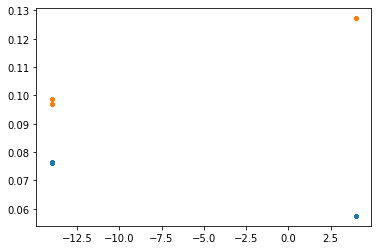

In [232]:
plt.plot(x_plot, y_test_plot, '.')
plt.plot(x_plot, y_pred, '.')


In [233]:
print(key)

H2O_O2,O3_N2,O3_air


In [ ]:
# change data files code


if 'Temperature' in file.columns:
        print(i, j)
        file['T'] = file['Temperature']
        file = file.drop(['Temperature'], axis=1)
    if 'Ka' in file.columns:
        print(i, j)
        file['Ka_aprox'] = file['Ka']
        file['Kc_aprox'] = file['Kc']
        file['Kapp_aprox'] = file['Kapp']
        file['Kcpp_aprox'] = file['Kcpp']
        file = file.drop(['Ka', 'Kc', 'Kapp', 'Kcpp'], axis=1)
    if 'local_iso_ID' in file.columns:
        print(i, j)
        file['local_iso_id'] = file['local_iso_ID']
        file = file.drop(['local_iso_ID'], axis=1)
    print(file.columns)
    file.to_csv(f)

In [ ]:
for key, data in db.items():
    if 'Temperature' in data.columns:
        print(key)
        print(data.columns)
        data['T'] = data['Temperature']
        data = data.drop(['Temperature'], axis=1)
    print(data.columns)